In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import os
import shutil
import random
import itertools
%matplotlib inline

In [2]:
mobile = tf.keras.applications.MobileNetV3Large()

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\applications\mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [3]:
os.getcwd()

'C:\\Users\\asus\\Documents\\Medicinal Herb Identification'

In [4]:
from tensorflow.keras.models import load_model
new_model = load_model('models/medicinal_herb_model.keras')

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 174 variables whereas the saved optimizer has 44 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [5]:
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, None, None, 3)     │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, None, None, 16)    │             432 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, None, None, 16)    │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, None, None, 16)    │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, None, None, 16)    │             144 │ activation[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, None, None, 16)    │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, None, None, 16)    │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, None, None, 16)    │             256 │ re_lu[0][0]                │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_bn      │ (None, None, None, 16)    │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_add (Add)       │ (None, None, None, 16)    │               0 │ activation[0][0],          │
│                               │                           │                 │ expanded_conv_project_bn[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand        │ (None, None, None, 64)    │           1,024 │ expanded_conv_add[0][0]    │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand_bn     │ (None, None, None, 64)    │             256 │ expanded_conv_1_expand[0]… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, None, None, 64)    │               

 Total params: 5,987,526 (22.84 MB)

 Trainable params: 2,981,562 (11.37 MB)

 Non-trainable params: 24,400 (95.31 KB)

 Optimizer params: 2,981,564 (11.37 MB)

In [6]:
def prepare_image(file):
    img_path='data/'
    img = image.load_img(img_path + file,target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array,axis=0)
    return tf.keras.applications.mobilenet_v3.preprocess_input(img_array_expanded_dims)

In [7]:
aimage='curry.png'
preprocessed_image=prepare_image(aimage)
predictions=new_model.predict(preprocessed_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [8]:
cm_plot_labels=['Mustard', 'Jackfruit', 'Cherry', 'Jamun', 'Jasmine', 'Karanda', 'Lemon', 'Mango', 'Mexican_Mint', 'Mint']

In [9]:
import numpy as np

# Assuming you have predictions and cm_plot_labels defined somewhere
# predictions = your array of predictions
# cm_plot_labels = your array of class labels

# Sorting indices to get the top 3 indices for each row
top3_indices = np.argsort(predictions, axis=-1)[:, -3:]
reversed_top3_indices = np.flip(top3_indices, axis=-1)

# Initialize an array to store class names
top3_class_names = np.empty_like(reversed_top3_indices, dtype=object)
top3_probabilities = np.empty_like(reversed_top3_indices, dtype=float)

# Iterate through each row of reversed_top3_indices
for i, row in enumerate(reversed_top3_indices):
    for j, idx in enumerate(row):
        # Assign class names
        top3_class_names[i, j] = cm_plot_labels[idx]
        # Assign probabilities
        top3_probabilities[i, j] = predictions[i, idx]
print(top3_probabilities[0][0])
if(top3_probabilities[0][0]<0.97):
    print("Not a Medicinal Plant")
else:
    print(top3_class_names[0][0])

0.965641975402832
Not a Medicinal Plant


[['Mango' 'Mustard' 'Mint']]


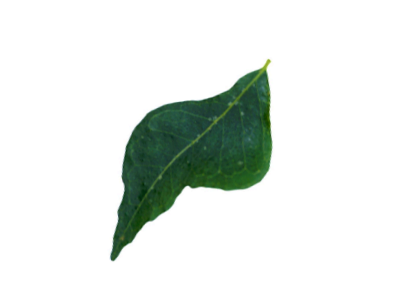

In [10]:
import numpy as np
top3_indices = np.argsort(predictions, axis =- 1) [:, -3:]
reversed_top3_indices = np.flip(top3_indices, axis =- 1)
top3_class_names = np.empty_like(reversed_top3_indices, dtype=object)
for i, row in enumerate(reversed_top3_indices):
    for j, idx in enumerate(row):
        top3_class_names[i, j] = cm_plot_labels[idx]
print(top3_class_names)
from PIL import Image
def show_image_with_size(image_path, width, height):
    img = Image.open(image_path)
    img_resized = img.resize((width, height))  
    display(img_resized)
image_path = "data/"+aimage
desired_width = 400
desired_height = 300
show_image_with_size(image_path, desired_width, desired_height)

In [17]:
train_path='dataset/train'
valid_path='dataset/valid'
test_path='dataset/test'

In [18]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input).flow_from_directory(directory=train_path,target_size=(224,224),batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input).flow_from_directory(directory=valid_path,target_size=(224,224),batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input).flow_from_directory(directory=test_path,target_size=(224,224),batch_size=10,shuffle=False)

Found 4360 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have a test dataset and you can get predictions
X_test= 'dataset/test'
y_test= ['Mustard', 'Jackfruit', 'Cherry', 'Jamun', 'Jasmine', 'Karanda', 'Lemon', 'Mango', 'Mexican_Mint', 'Mint']
# predictions: Predicted probabilities

from sklearn.preprocessing import LabelEncoder

# Initialize a label encoder
label_encoder = LabelEncoder()

# Fit label encoder and transform y_test to numerical labels
y_test_numerical = label_encoder.fit_transform(y_test)

# Initialize lists to store fpr, tpr, and auc for each class
class_fpr = dict()
class_tpr = dict()
class_auc = dict()

# Loop through each class
for i in range(len(cm_plot_labels)):
    # Get the predicted probabilities for the current class
    class_probs = predictions[:, i]

    print("Predicted probabilities for class", cm_plot_labels[i], ":", class_probs)

    # Get true labels for the current class
    class_true_labels = (y_test_numerical == i).astype(int)

    # Calculate fpr, tpr, and auc for the current class
    class_fpr[i], class_tpr[i], _ = roc_curve(class_true_labels, class_probs)
    class_auc[i] = auc(class_fpr[i], class_tpr[i])


# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(cm_plot_labels)):
    plt.plot(class_fpr[i], class_tpr[i], lw=2, label='ROC curve (area = %0.2f) for %s' % (class_auc[i], cm_plot_labels[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
plt.legend(loc="lower right")
plt.show()


Predicted probabilities for class Mustard : [0.03277433]


ValueError: Found input variables with inconsistent numbers of samples: [10, 1]

In [27]:
print("Shape of predictions:", predictions.shape)
for i in range(len(cm_plot_labels)):
    print("Predictions for class", cm_plot_labels[i], ":", predictions[:, i][:5])


Shape of predictions: (1, 10)
Predictions for class Mustard : [0.03277433]
Predictions for class Jackfruit : [9.221836e-06]
Predictions for class Cherry : [1.1873701e-06]
Predictions for class Jamun : [2.2212433e-05]
Predictions for class Jasmine : [0.00016964]
Predictions for class Karanda : [5.849289e-05]
Predictions for class Lemon : [9.248805e-06]
Predictions for class Mango : [0.965642]
Predictions for class Mexican_Mint : [1.9351248e-06]
Predictions for class Mint : [0.00131176]
